In [177]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.cluster.hierarchy import fcluster

from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, roc_curve, auc
from sklearn.model_selection import train_test_split


import warnings
warnings.filterwarnings('ignore')



In [77]:
# Define the Dow Jones Index stock symbols excluding 'FB'
dow_symbols = ["AAPL", "MSFT", "AMZN", "GOOGL", "GOOG", "TSLA", "BABA", "TSM", "V", 
               "JPM", "JNJ", "NVDA", "PYPL", "HD", "ASML", "DIS", "CMCSA", "BAC", "NFLX",
               "WMT", "CSCO", "PG", "INTC", "VZ", "T", "ADBE", "KO", "PEP", "TMUS", "ORCL"]

# Download historical data
data = yf.download(dow_symbols, start="2022-01-01", end="2023-01-01")[['Adj Close']]


data.columns = data.columns.droplevel(0)


# Calculate daily returns
returns = data.pct_change().dropna()

# Handle missing and infinite values
returns = returns.replace([np.inf, -np.inf], np.nan).dropna()

# Calculate the correlation matrix
correlation_matrix = returns.corr()

# Perform PCA
pca = PCA()
pca.fit(correlation_matrix)

# Get principal components
principal_components = pca.components_



[*********************100%%**********************]  30 of 30 completed


In [63]:
# data.to_csv('yahoofinance_data.csv', index=True)


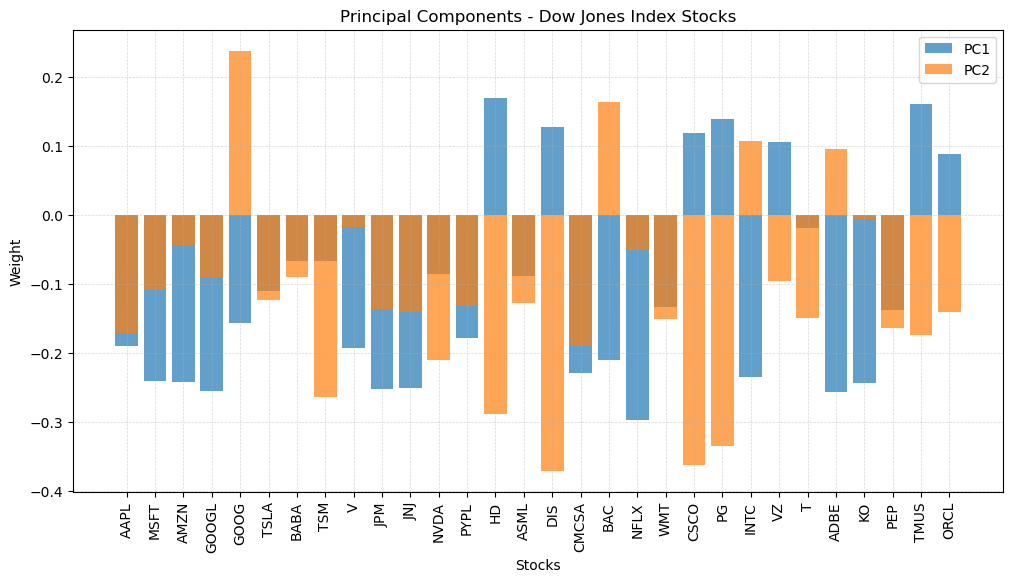

In [78]:

# Plot bar graphs for the first principal component
plt.figure(figsize=(12, 6))
plt.bar(range(len(dow_symbols)), principal_components[0], alpha=0.7, label='PC1')# ax = axes[0])
plt.bar(range(len(dow_symbols)), principal_components[1], alpha=0.7, label='PC2')
plt.xticks(range(len(dow_symbols)), dow_symbols, rotation=90)
plt.title('Principal Components - Dow Jones Index Stocks')
plt.xlabel('Stocks')
plt.ylabel('Weight')
plt.legend()
plt.grid(True, linestyle = '--', linewidth = 0.5, alpha = 0.5)
plt.show()

# 1.4

Number of principal components to explain 95% of the variance: 12


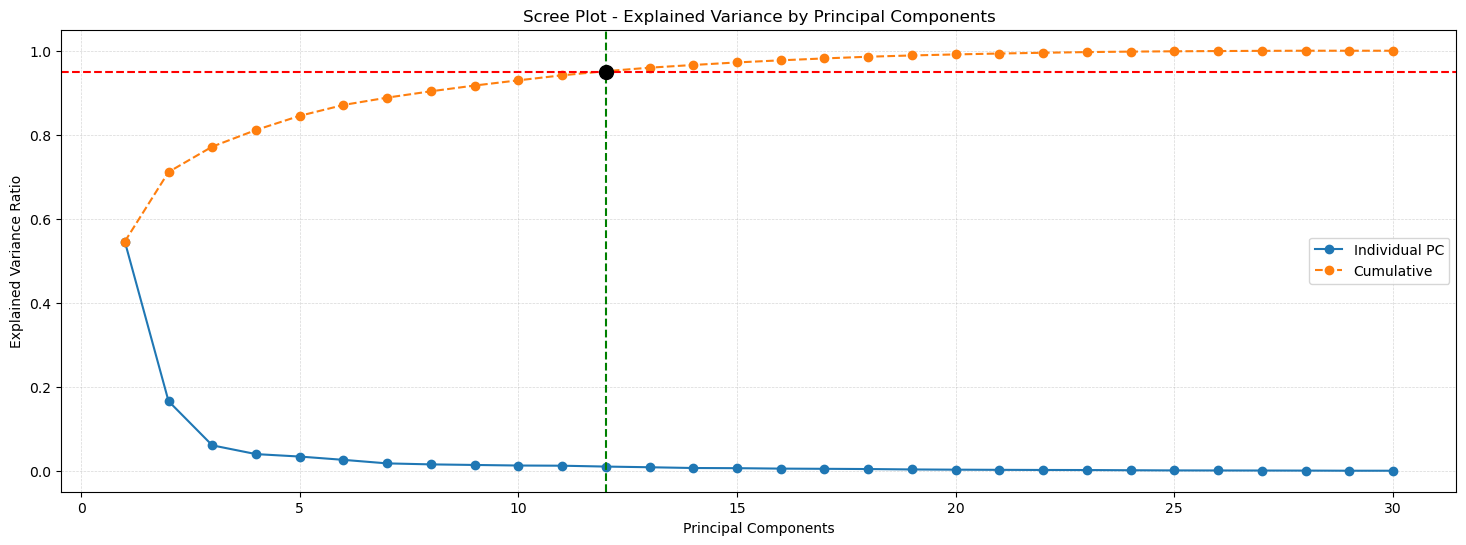

In [80]:
# Get the explained variances
explained_variances = pca.explained_variance_ratio_

# Cumulative sum of explained variances
cumulative_variances = np.cumsum(explained_variances)

# Determine the number of principal components required to explain 95% of the variance
num_components_95_percent = np.argmax(cumulative_variances >= 0.95) + 1
print(f'Number of principal components to explain 95% of the variance: {num_components_95_percent}')

# Plot the 'Scree' plot
plt.figure(figsize=(18, 6))
plt.plot(range(1, len(explained_variances) + 1), explained_variances, marker='o', label='Individual PC')
plt.plot(range(1, len(cumulative_variances) + 1), cumulative_variances, marker='o', linestyle='--', label='Cumulative')
plt.title('Scree Plot - Explained Variance by Principal Components')
plt.xlabel('Principal Components')
plt.ylabel('Explained Variance Ratio')
plt.legend()
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.5)
plt.axhline(y=0.95, color='red', linestyle='--', label='95% Variance')
plt.axvline(x=num_components_95_percent, color='green', linestyle='--', label='Required PC')
plt.plot(num_components_95_percent, 0.95, marker='o', color='black', markersize=10)
plt.show()



# 1.5

In [82]:


pc1_average = np.mean(principal_components[0])
pc2_average = np.mean(principal_components[1])


# Calculate the distance from each company to the average of the first principal component
distance_pc1 = np.abs(principal_components[0] - pc1_average)
pc1_average = np.mean(distance_pc1)
dist1_dataframe = pd.DataFrame(distance_pc1, columns=['distance_pc1'], index=dow_symbols)

# calculate the distance from each company to the average of the second principal component
distance_pc2 = np.abs(principal_components[1] - pc2_average)
pc2_average = np.mean(distance_pc2)

dist2_dataframe = pd.DataFrame(distance_pc2, columns=['distance_pc2'], index=dow_symbols)



dist1_dataframe.index.name = 'Symbol'
dist2_dataframe.index.name = 'Symbol'

# merge the two dataframes
# merged_df = dist1_dataframe.merge(dist2_dataframe)
# merged_df

merged_df = dist1_dataframe.merge(dist2_dataframe, left_index=True, right_index=True)


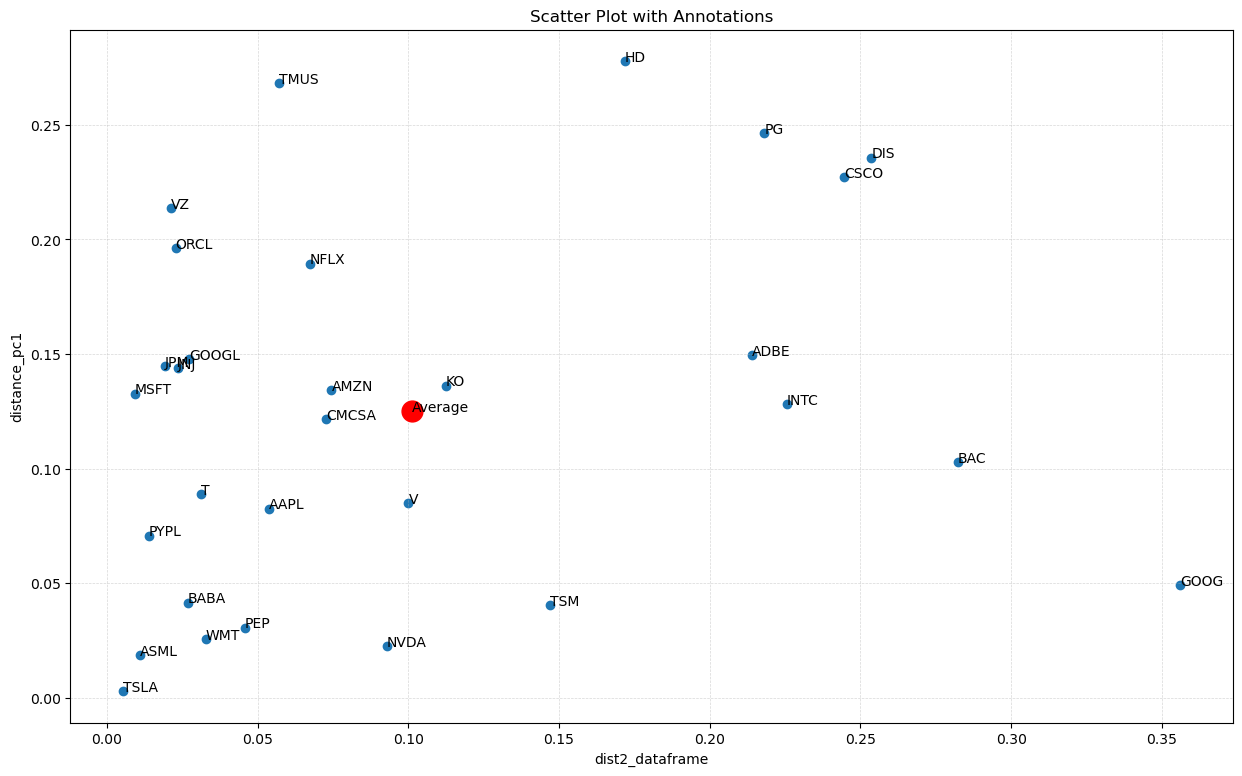

In [68]:
# plt.scatter(dist2_dataframe, distance_pc1)
# plt.plot(pca_2_average, pc1_average,  'ro', markersize=10, label='Average')
# plt.show()

# Assuming you have dist2_dataframe, distance_pc1, pca_2_average, and pc1_average


plt.figure(figsize=(15, 9))
plt.scatter(merged_df['distance_pc2'], merged_df['distance_pc1'])
plt.plot(pc2_average, pc1_average, 'ro', markersize=15, label='Average')
plt.annotate('Average', (pc2_average, pc1_average))

# Annotate each point with the corresponding index
# Annotations
for i, txt in enumerate(merged_df.index):
    plt.annotate(txt, (merged_df['distance_pc2'][i], merged_df['distance_pc1'][i]))

plt.xlabel('dist2_dataframe')
plt.ylabel('distance_pc1')
plt.title('Scatter Plot with Annotations')
# plt.legend()
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.5)
plt.show()


# Exercises 2

## 1.


**a dendrogram** is a tree diagram that helps us in depicting the arrangements and merging of clusters. It helps us interpret the relkationsp with clustered data [1].

To construct a dendrogram, we first need a dissimilarity or distance matrix containing the pairwise distances between all data points. [1]

The basic components of a dendrogram are:

Branches - These connect clusters that have been merged together during the hierarchical clustering process.

Leaf nodes - These represent each individual data point at the start before any mergers occur.

Height - The height of each branch represents the distance or dissimilarity between the two clusters that were merged.

To construct the dendrogram, we start by treating each data point as its own cluster. We then iteratively identify the two closest clusters and merge them into a single new cluster. When a merge occurs, we calculate the distance between the new cluster and each of the remaining individual points or existing clusters.

This process repeats, each time merging the two clusters with the smallest distance, until all observations are merged into a single cluster. The results are typically visualized with the leaf nodes on the left or bottom, connected by branches that merge clusters moving to the right or top.

We can interpret the dendrogram by "cutting" the tree horizontally at different heights. All clusters connected below a cut line would be separate groups identified at that level of dissimilarity. So dendrograms help visualize the hierarchical relationships between observations and can assist in determining the optimal number of clusters.

To construct a dendrogram, we first need a dissimilarity or distance matrix containing the pairwise distances between all data points. [1]

The basic components of a dendrogram are:

Branches - These connect clusters that have been merged together during the hierarchical clustering process.

Leaf nodes - These represent each individual data point at the start before any mergers occur.

Height - The height of each branch represents the distance or dissimilarity between the two clusters that were merged.

To construct the dendrogram, we start by treating each data point as its own cluster. We then iteratively identify the two closest clusters and merge them into a single new cluster. When a merge occurs, we calculate the distance between the new cluster and each of the remaining individual points or existing clusters.

This process repeats, each time merging the two clusters with the smallest distance, until all observations are merged into a single cluster. The results are typically visualized with the leaf nodes on the left or bottom, connected by branches that merge clusters moving to the right or top.

We can interpret the dendrogram by "cutting" the tree horizontally at different heights. All clusters connected below a cut line would be separate groups identified at that level of dissimilarity. So dendrograms help visualize the hierarchical relationships between observations and can assist in determining the optimal number of clusters.

1. https://www.askpython.com/python/examples/dendrograms-in-python


# 2

Here are the typical steps involved in constructing a dendrogram from a collection of pairwise dissimilarity values:

Calculate the dissimilarity matrix: This contains all the pairwise dissimilarity values between data points. For example, if there are 5 data points, the matrix would be 5x5 with the dissimilarity between each pair along the diagonal.

Linkage: Decide how clusters will be linked as the dendrogram is constructed. Common methods include single, complete, average/UPGMA linkage.

Initially, each data point starts in its own cluster. Find the closest pair of clusters and merge them into a single cluster, computing the new dissimilarity level between the merged cluster and each of the other clusters.

Repeat step 3, each time merging the two closest clusters, recomputing dissimilarities between the new cluster and each of the remaining old clusters. Continue until all data points are merged into a single cluster.

Draw the dendrogram: This shows the cluster mergers as branches linking at the dissimilarity level where each merger occurred. The vertical axis represents the dissimilarity levels while the horizontal axis represents the data points.

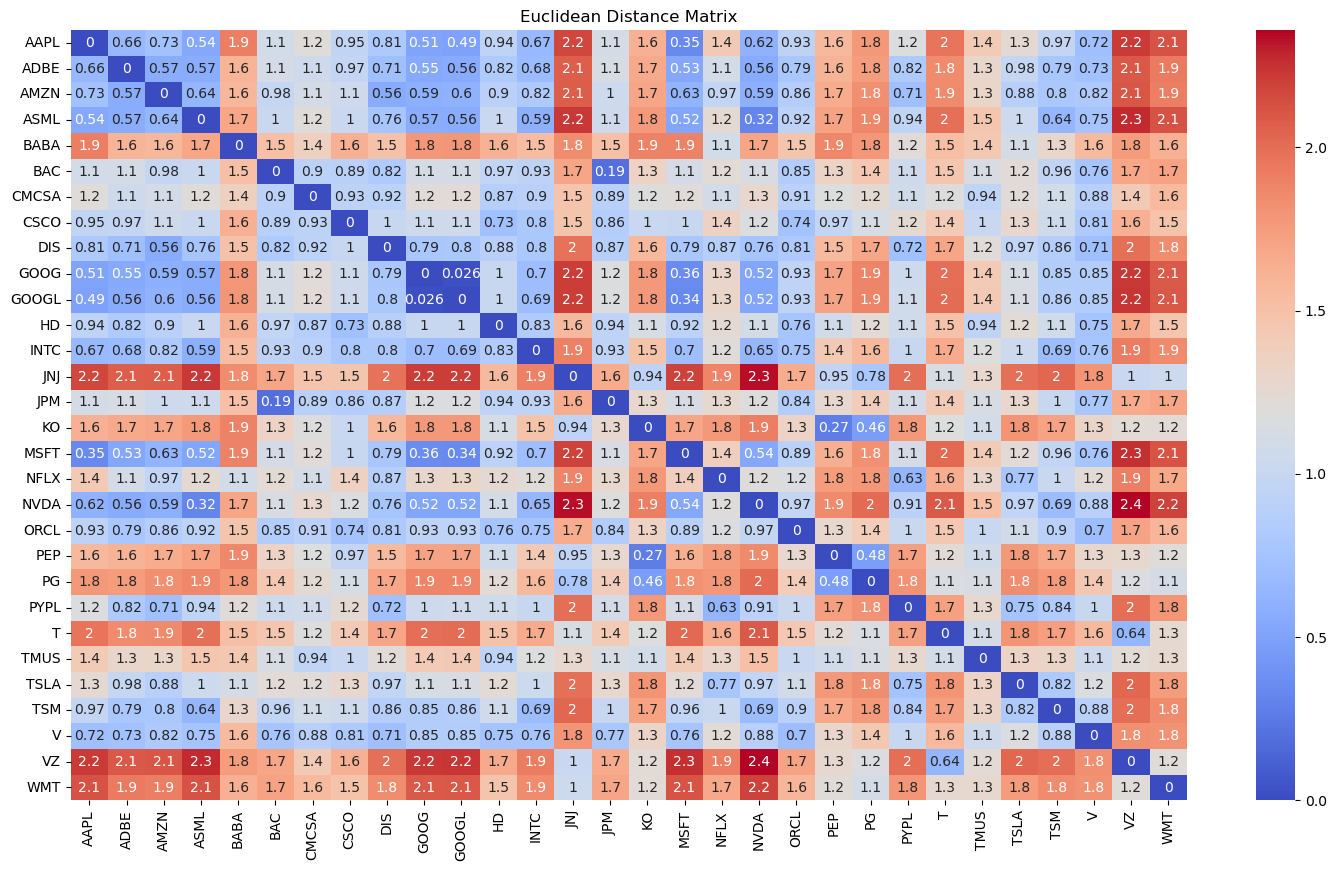

In [120]:
# Example usage:


def euclidean_distance(x, y):
    return np.sqrt(np.sum((x - y)**2))

num_stocks = correlation_matrix.shape[1]
distances = np.empty((num_stocks, num_stocks))

column = 0
row = 0

for i in correlation_matrix.columns:
    column = 0  # Reset column index for each row
    for j in correlation_matrix.columns:
        distances[row, column] = euclidean_distance(correlation_matrix[i], correlation_matrix[j])
        column += 1
    row += 1

# plt.figure(figsize=(16, 10))
# sns.heatmap(distances, annot=True, cmap='coolwarm')

distances = pd.DataFrame(distances, index=correlation_matrix.columns, columns=correlation_matrix.columns)

plt.figure(figsize=(18, 10))
sns.heatmap(distances, annot=True, cmap='coolwarm')
plt.title('Euclidean Distance Matrix')
plt.show()


**a dendrogram** is a tree diagram that helps us in depicting the arrangements and merging of clusters. It helps us interpret the relkationsp with clustered data [1].

To construct a dendrogram, we first need a dissimilarity or distance matrix containing the pairwise distances between all data points. [1]

The basic components of a dendrogram are:

Branches - These connect clusters that have been merged together during the hierarchical clustering process.

Leaf nodes - These represent each individual data point at the start before any mergers occur.

Height - The height of each branch represents the distance or dissimilarity between the two clusters that were merged.

To construct the dendrogram, we start by treating each data point as its own cluster. We then iteratively identify the two closest clusters and merge them into a single new cluster. When a merge occurs, we calculate the distance between the new cluster and each of the remaining individual points or existing clusters.

This process repeats, each time merging the two clusters with the smallest distance, until all observations are merged into a single cluster. The results are typically visualized with the leaf nodes on the left or bottom, connected by branches that merge clusters moving to the right or top.

We can interpret the dendrogram by "cutting" the tree horizontally at different heights. All clusters connected below a cut line would be separate groups identified at that level of dissimilarity. So dendrograms help visualize the hierarchical relationships between observations and can assist in determining the optimal number of clusters.

To construct a dendrogram, we first need a dissimilarity or distance matrix containing the pairwise distances between all data points. [1]

The basic components of a dendrogram are:

Branches - These connect clusters that have been merged together during the hierarchical clustering process.

Leaf nodes - These represent each individual data point at the start before any mergers occur.

Height - The height of each branch represents the distance or dissimilarity between the two clusters that were merged.

To construct the dendrogram, we start by treating each data point as its own cluster. We then iteratively identify the two closest clusters and merge them into a single new cluster. When a merge occurs, we calculate the distance between the new cluster and each of the remaining individual points or existing clusters.

This process repeats, each time merging the two clusters with the smallest distance, until all observations are merged into a single cluster. The results are typically visualized with the leaf nodes on the left or bottom, connected by branches that merge clusters moving to the right or top.

We can interpret the dendrogram by "cutting" the tree horizontally at different heights. All clusters connected below a cut line would be separate groups identified at that level of dissimilarity. So dendrograms help visualize the hierarchical relationships between observations and can assist in determining the optimal number of clusters.

1. https://www.askpython.com/python/examples/dendrograms-in-python



**a dendrogram** is a tree diagram that helps us in depicting the arrangements and merging of clusters. It helps us interpret the relkationsp with clustered data [1].

To construct a dendrogram, we first need a dissimilarity or distance matrix containing the pairwise distances between all data points. [1]

The basic components of a dendrogram are:

Branches - These connect clusters that have been merged together during the hierarchical clustering process.

Leaf nodes - These represent each individual data point at the start before any mergers occur.

Height - The height of each branch represents the distance or dissimilarity between the two clusters that were merged.

To construct the dendrogram, we start by treating each data point as its own cluster. We then iteratively identify the two closest clusters and merge them into a single new cluster. When a merge occurs, we calculate the distance between the new cluster and each of the remaining individual points or existing clusters.

This process repeats, each time merging the two clusters with the smallest distance, until all observations are merged into a single cluster. The results are typically visualized with the leaf nodes on the left or bottom, connected by branches that merge clusters moving to the right or top.

We can interpret the dendrogram by "cutting" the tree horizontally at different heights. All clusters connected below a cut line would be separate groups identified at that level of dissimilarity. So dendrograms help visualize the hierarchical relationships between observations and can assist in determining the optimal number of clusters.

To construct a dendrogram, we first need a dissimilarity or distance matrix containing the pairwise distances between all data points. [1]

The basic components of a dendrogram are:

Branches - These connect clusters that have been merged together during the hierarchical clustering process.

Leaf nodes - These represent each individual data point at the start before any mergers occur.

Height - The height of each branch represents the distance or dissimilarity between the two clusters that were merged.

To construct the dendrogram, we start by treating each data point as its own cluster. We then iteratively identify the two closest clusters and merge them into a single new cluster. When a merge occurs, we calculate the distance between the new cluster and each of the remaining individual points or existing clusters.

This process repeats, each time merging the two clusters with the smallest distance, until all observations are merged into a single cluster. The results are typically visualized with the leaf nodes on the left or bottom, connected by branches that merge clusters moving to the right or top.

We can interpret the dendrogram by "cutting" the tree horizontally at different heights. All clusters connected below a cut line would be separate groups identified at that level of dissimilarity. So dendrograms help visualize the hierarchical relationships between observations and can assist in determining the optimal number of clusters.

1. https://www.askpython.com/python/examples/dendrograms-in-python



**a dendrogram** is a tree diagram that helps us in depicting the arrangements and merging of clusters. It helps us interpret the relkationsp with clustered data [1].

To construct a dendrogram, we first need a dissimilarity or distance matrix containing the pairwise distances between all data points. [1]

The basic components of a dendrogram are:

Branches - These connect clusters that have been merged together during the hierarchical clustering process.

Leaf nodes - These represent each individual data point at the start before any mergers occur.

Height - The height of each branch represents the distance or dissimilarity between the two clusters that were merged.

To construct the dendrogram, we start by treating each data point as its own cluster. We then iteratively identify the two closest clusters and merge them into a single new cluster. When a merge occurs, we calculate the distance between the new cluster and each of the remaining individual points or existing clusters.

This process repeats, each time merging the two clusters with the smallest distance, until all observations are merged into a single cluster. The results are typically visualized with the leaf nodes on the left or bottom, connected by branches that merge clusters moving to the right or top.

We can interpret the dendrogram by "cutting" the tree horizontally at different heights. All clusters connected below a cut line would be separate groups identified at that level of dissimilarity. So dendrograms help visualize the hierarchical relationships between observations and can assist in determining the optimal number of clusters.

To construct a dendrogram, we first need a dissimilarity or distance matrix containing the pairwise distances between all data points. [1]

The basic components of a dendrogram are:

Branches - These connect clusters that have been merged together during the hierarchical clustering process.

Leaf nodes - These represent each individual data point at the start before any mergers occur.

Height - The height of each branch represents the distance or dissimilarity between the two clusters that were merged.

To construct the dendrogram, we start by treating each data point as its own cluster. We then iteratively identify the two closest clusters and merge them into a single new cluster. When a merge occurs, we calculate the distance between the new cluster and each of the remaining individual points or existing clusters.

This process repeats, each time merging the two clusters with the smallest distance, until all observations are merged into a single cluster. The results are typically visualized with the leaf nodes on the left or bottom, connected by branches that merge clusters moving to the right or top.

We can interpret the dendrogram by "cutting" the tree horizontally at different heights. All clusters connected below a cut line would be separate groups identified at that level of dissimilarity. So dendrograms help visualize the hierarchical relationships between observations and can assist in determining the optimal number of clusters.

1. https://www.askpython.com/python/examples/dendrograms-in-python


#### 2.4. A dendrogram that visualizes a clustering hierarchy is often integrated with a reorderable matrix for pattern identification.

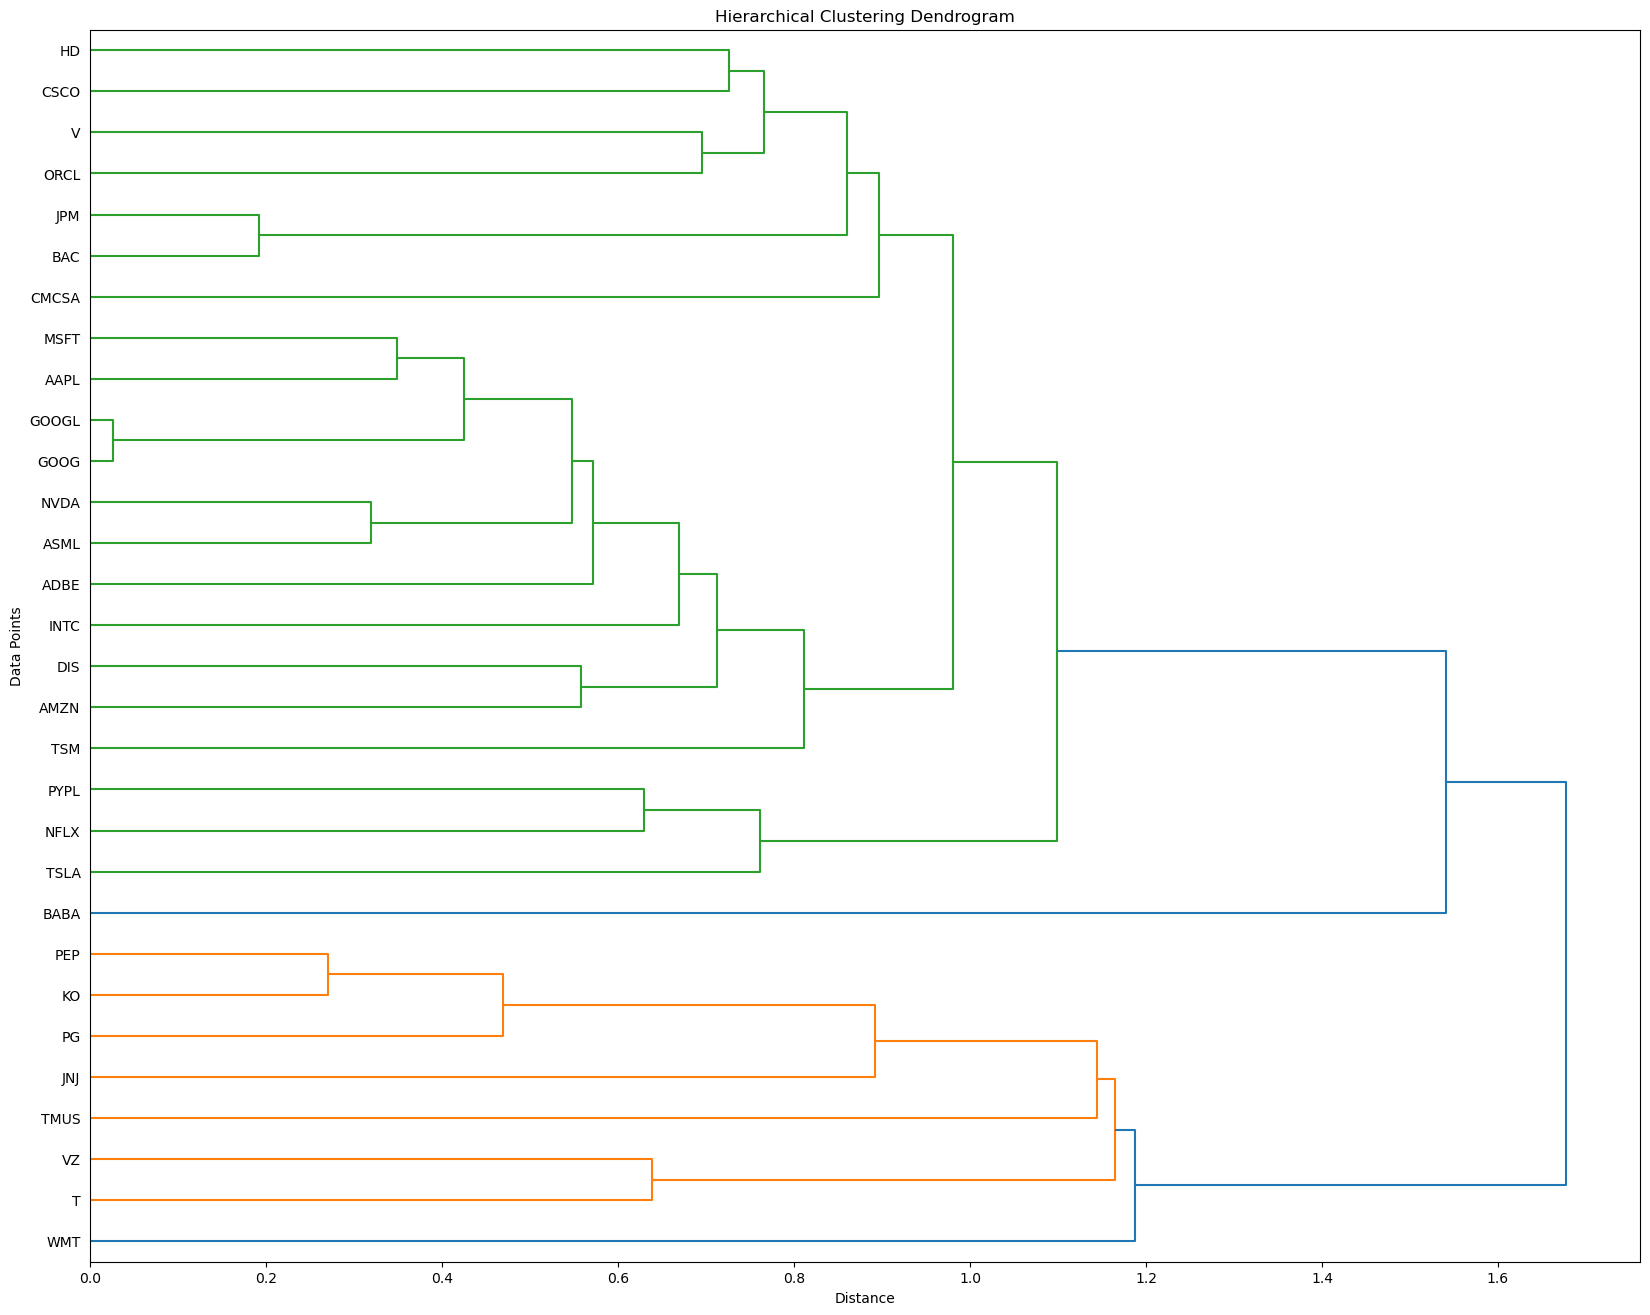

In [152]:


def create_dendrogram(data, method='average', metric='euclidean', figsize=(10, 6), orientation='top', labels=None):
    """
    Create a dendrogram using hierarchical clustering.

    Parameters:
    - data: 2D array-like or DataFrame
        The input data for clustering.
    - method: str, optional (default='average')
        The linkage algorithm to use. It could be 'single', 'complete', 'average', or others.
    - metric: str, optional (default='euclidean')
        The distance metric to use for clustering.
    - figsize: tuple, optional (default=(10, 6))
        The size of the figure.
    - orientation: str, optional (default='top')
        The orientation of the dendrogram. It could be 'top', 'right', 'bottom', or 'left'.
    - labels: list, optional (default=None)
        The labels for the data points.

    Returns:
    - None
        Displays the dendrogram.
    """
    # Perform hierarchical clustering
    linkage_matrix = linkage(data, method=method, metric=metric)

    # Create dendrogram
    plt.figure(figsize=figsize)
    dendrogram(linkage_matrix, labels=data.index, orientation=orientation)

    # Set plot parameters
   
    plt.title('Hierarchical Clustering Dendrogram')
    plt.ylabel('Data Points')
    plt.xlabel('Distance')

    # Show the plot
    plt.show()
    return linkage_matrix


# Create dendrogram with default parameters
linkage_matrix = create_dendrogram(correlation_matrix, method='average', metric='euclidean', figsize=(20, 16), orientation='right', labels=None)


# 2.5

In [154]:


# Assuming you already have your linkage_matrix
linkage_matrix = linkage_matrix

# Set the number of clusters (you may need to adjust this based on your data)
num_clusters = 3

# Cut the dendrogram to form clusters
clusters = fcluster(linkage_matrix, num_clusters, criterion='maxclust')

# Assign each stock to its respective cluster
stocks_by_cluster = {cluster: [] for cluster in set(clusters)}
for stock, cluster in zip(correlation_matrix.columns, clusters):
    stocks_by_cluster[cluster].append(stock)

# Display the stocks in each cluster
for cluster, stocks in stocks_by_cluster.items():
    print(f"Cluster {cluster}: {stocks}")


Cluster 1: ['JNJ', 'KO', 'PEP', 'PG', 'T', 'TMUS', 'VZ', 'WMT']
Cluster 2: ['AAPL', 'ADBE', 'AMZN', 'ASML', 'BAC', 'CMCSA', 'CSCO', 'DIS', 'GOOG', 'GOOGL', 'HD', 'INTC', 'JPM', 'MSFT', 'NFLX', 'NVDA', 'ORCL', 'PYPL', 'TSLA', 'TSM', 'V']
Cluster 3: ['BABA']


# EX 3. Ensemble for classification

# 3.1.
**a dendrogram** is a tree diagram that helps us in depicting the arrangements and merging of clusters. It helps us interpret the relkationsp with clustered data [1].

To construct a dendrogram, we first need a dissimilarity or distance matrix containing the pairwise distances between all data points. [1]

The basic components of a dendrogram are:

Branches - These connect clusters that have been merged together during the hierarchical clustering process.

Leaf nodes - These represent each individual data point at the start before any mergers occur.

Height - The height of each branch represents the distance or dissimilarity between the two clusters that were merged.

To construct the dendrogram, we start by treating each data point as its own cluster. We then iteratively identify the two closest clusters and merge them into a single new cluster. When a merge occurs, we calculate the distance between the new cluster and each of the remaining individual points or existing clusters.

This process repeats, each time merging the two clusters with the smallest distance, until all observations are merged into a single cluster. The results are typically visualized with the leaf nodes on the left or bottom, connected by branches that merge clusters moving to the right or top.

We can interpret the dendrogram by "cutting" the tree horizontally at different heights. All clusters connected below a cut line would be separate groups identified at that level of dissimilarity. So dendrograms help visualize the hierarchical relationships between observations and can assist in determining the optimal number of clusters.



In [189]:
test_scores

array([[0.50381679, 0.6870229 , 0.67938931, 0.67557252, 0.64367816],
       [0.51526718, 0.76717557, 0.69083969, 0.67938931, 0.62452107],
       [0.51526718, 0.74427481, 0.69465649, 0.6870229 , 0.63601533],
       [0.51526718, 0.75954198, 0.69847328, 0.66793893, 0.63601533],
       [0.51526718, 0.73282443, 0.71755725, 0.67557252, 0.64367816],
       [0.51526718, 0.79007634, 0.71374046, 0.67557252, 0.62068966],
       [0.51526718, 0.78625954, 0.69083969, 0.68320611, 0.64367816],
       [0.51526718, 0.79007634, 0.69083969, 0.68320611, 0.62835249],
       [0.51526718, 0.7480916 , 0.70229008, 0.6870229 , 0.62835249],
       [0.51526718, 0.72519084, 0.71374046, 0.66793893, 0.63984674],
       [0.51526718, 0.79389313, 0.69465649, 0.66793893, 0.61685824],
       [0.51526718, 0.73664122, 0.69083969, 0.67175573, 0.63984674],
       [0.51526718, 0.77099237, 0.69465649, 0.66793893, 0.63601533],
       [0.51526718, 0.79389313, 0.70229008, 0.68320611, 0.64367816],
       [0.51526718, 0.80534351, 0.


# 3.1.
**a dendrogram** is a tree diagram that helps us in depicting the arrangements and merging of clusters. It helps us interpret the relkationsp with clustered data [1].



To construct a dendrogram, we first need a dissimilarity or distance matrix containing the pairwise distances between all data points. [1]

The basic components of a dendrogram are:

Branches - These connect clusters that have been merged together during the hierarchical clustering process.

Leaf nodes - These represent each individual data point at the start before any mergers occur.

Height - The height of each branch represents the distance or dissimilarity between the two clusters that were merged.

## 3.2.

To construct the dendrogram, we start by treating each data point as its own cluster. We then iteratively identify the two closest clusters and merge them into a single new cluster. When a merge occurs, we calculate the distance between the new cluster and each of the remaining individual points or existing clusters.

This process repeats, each time merging the two clusters with the smallest distance, until all observations are merged into a single cluster. The results are typically visualized with the leaf nodes on the left or bottom, connected by branches that merge clusters moving to the right or top.

We can interpret the dendrogram by "cutting" the tree horizontally at different heights. All clusters connected below a cut line would be separate groups identified at that level of dissimilarity. So dendrograms help visualize the hierarchical relationships between observations and can assist in determining the optimal number of clusters.

1. https://www.askpython.com/python/examples/dendrograms-in-python


In [239]:
from sklearn.metrics import classification_report
from sklearn.model_selection import validation_curve
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score


df = pd.read_csv('titanic3.csv', usecols = ['survived', 'pclass', 'sex', 'age'])
df['age'].fillna(df['age'].mean(), inplace = True)

# get dummies
df = pd.get_dummies(df, columns=['sex'], drop_first=True)


# split data into train and test
X_train, X_test, y_train, y_test = train_test_split(df.drop('survived', axis=1), df['survived'], test_size=0.3, random_state=42)
# Create a random forest classifier

metrics = {'accuracy_score':[], 'num estimators':[]}
best_mode = None
optimal_trees = None

for i in range(1, 200):
    rf_model = RandomForestClassifier(n_estimators=i, oob_score=True, random_state=42)
    rf_model.fit(X_train, y_train)
    y_pred = rf_model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)

    if i == 1:
        best_mode = rf_model
    else:
        if accuracy > max(metrics['accuracy_score']):
            best_mode = rf_model
            optimal_trees = i
        else:
            pass

    metrics['accuracy_score'].append(accuracy)
    metrics['num estimators'].append(i)

print(f'The number of trees is {optimal_trees}')
    
plt.plot(metrics['num estimators'], metrics['accuracy_score'], '-o')
plt.grid(True, which='both', linestyle='--', color='gray', alpha = 0.3)
plt.show()



# 3.5. ROC curves

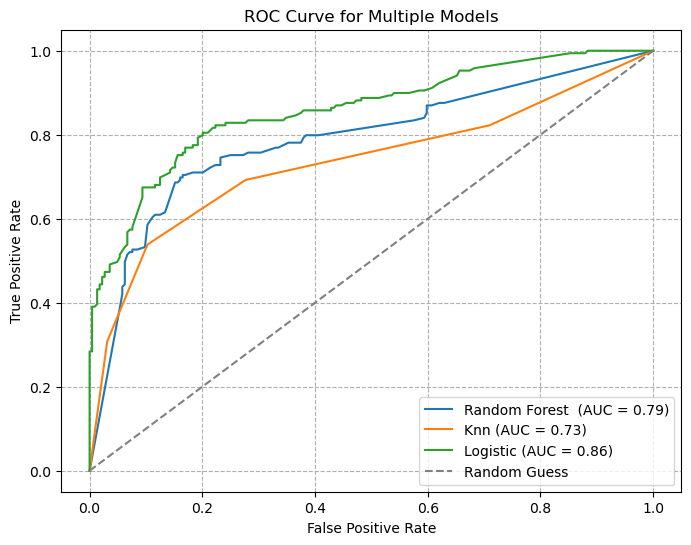

In [238]:

plt.figure(figsize=(8, 6))
y_prob = best_mode.predict_proba(X_test)[:, 1]

# Calculate ROC curve
fpr, tpr, _ = roc_curve(y_test, y_prob)

# Calculate AUC score
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.plot(fpr, tpr, label=f'Random Forest  (AUC = {roc_auc:.2f})')

# Define your models
models = [
    ('Knn', KNeighborsClassifier()),
    ('Logistic', LogisticRegression())
]



# Train and evaluate each model and also plot the ROC curve for each model
for name, model in models:
    model.fit(X_train, y_train)
    
    # Get predicted probabilities
    y_prob = model.predict_proba(X_test)[:, 1]
    
    # Calculate ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    
    # Calculate AUC score
    roc_auc = auc(fpr, tpr)
    
    # Plot ROC curve
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')

# Plot the random guess line
plt.plot([0.0, 1.0], [0.0, 1.0], linestyle='--', color='gray', label='Random Guess')

# Set labels and title
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multiple Models')
plt.legend(loc = 'best')
plt.grid(True, linestyle='--')
plt.show()
